In [2]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from scikeras.wrappers import KerasClassifier

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import joblib

plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

# Charger X_full / y_full sauvegardés depuis data_exploration
data_dir = Path("/data/processed")
X_full = joblib.load(data_dir / "X_full.joblib")
y_full = joblib.load(data_dir / "y_full.joblib")

print("Shape X_full:", X_full.shape)
print("Shape y_full:", y_full.shape)
print("Classes :", np.unique(y_full))
RANDOM_STATE = 42

Shape X_full: (10299, 561)
Shape y_full: (10299,)
Classes : [1 2 3 4 5 6]


In [3]:
from pathlib import Path
import mlflow
import mlflow.sklearn

mlruns_dir = Path(r"C:\Users\hp\Downloads\MLFLOW_HumanActivity\mlruns_new")
mlruns_dir.mkdir(parents=True, exist_ok=True)

mlruns_uri = mlruns_dir.as_uri()  

mlflow.set_tracking_uri(mlruns_uri)
mlflow.set_experiment("HAR_exp")

print("MLflow tracking URI =", mlflow.get_tracking_uri())


MLflow tracking URI = file:///C:/Users/hp/Downloads/MLFLOW_HumanActivity/mlruns_new


d:\Projet_ML\MLFLOW_HumanActivity\.venv\Lib\site-packages\mlflow\tracking\_tracking_service\utils.py:140: FutureWarning: Filesystem tracking backend (e.g., './mlruns') is deprecated. Please switch to a database backend (e.g., 'sqlite:///mlflow.db'). For feedback, see: https://github.com/mlflow/mlflow/issues/18534
  return FileStore(store_uri, store_uri)


In [4]:
with mlflow.start_run(run_name="test_run"):
    mlflow.log_param("model_name", "dummy")
    mlflow.log_metric("accuracy", 0.123)

print("Run de test MLflow loggé.")

Run de test MLflow loggé.


In [5]:

X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.2,
    random_state=42,
    stratify=y_full
)

print("X_train:", X_train.shape, "X_test:", X_test.shape)


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
n_features = X_train.shape[1]
n_classes = len(np.unique(y_train))

X_train: (8239, 561) X_test: (2060, 561)


In [6]:


def build_mlp(
    n_features=n_features,
    n_classes=n_classes,
    n_hidden1=256,
    n_hidden2=128,
    dropout_rate=0.4,
):
    model = keras.Sequential([
        layers.Input(shape=(n_features,)),
        layers.Dense(n_hidden1, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(n_hidden2, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(dropout_rate),

        layers.Dense(n_classes, activation="softmax"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

early_stop = EarlyStopping(
    monitor="loss",
    patience=3,
    restore_best_weights=True,
)

mlp_clf = KerasClassifier(
    model=build_mlp,
    n_features=n_features,
    n_classes=n_classes,
    epochs=30,
    batch_size=128,
    verbose=0,
    random_state=RANDOM_STATE,
    callbacks=[early_stop],
)

mlp_param_grid = {
    "model__n_hidden1": [256, 384],
    "model__n_hidden2": [128],
    "model__dropout_rate": [0.3, 0.5],
    "batch_size": [64, 128],
}



log_reg = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        (
            "clf",
            LogisticRegression(
                multi_class="multinomial",
                solver="lbfgs",
                max_iter=1000,
                random_state=RANDOM_STATE,
            ),
        ),
    ]
)

log_reg_param_grid = {
    "clf__C": [0.1, 1.0, 10.0],
}

rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

rf_param_grid = {
    "max_depth": [None, 25],
    "min_samples_split": [2, 5],
}

svm_rbf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("clf", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)),
    ]
)

svm_param_grid = {
    "clf__C": [1.0, 10.0],
    "clf__gamma": ["scale"],
}


search_space = {
    "log_reg": {
        "estimator": log_reg,
        "param_grid": log_reg_param_grid,
    },
    "random_forest": {
        "estimator": rf_clf,
        "param_grid": rf_param_grid,
    },
    "svm_rbf": {
        "estimator": svm_rbf,
        "param_grid": svm_param_grid,
    },
    "mlp_keras": {
        "estimator": mlp_clf,
        "param_grid": mlp_param_grid,
    },
}

print("LogReg, RF, SVM et MLP Keras définis pour la GridSearch.")


LogReg, RF, SVM et MLP Keras définis pour la GridSearch.


: 

In [7]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_results = {}

for name, cfg in search_space.items():
    print("\n=======================")
    print(f"GridSearch for: {name}")
    print("=======================")

    estimator = cfg["estimator"]
    param_grid = cfg["param_grid"]

    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring="accuracy",
        n_jobs=1,
        cv=cv,
        verbose=1
    )


    grid.fit(X_train_scaled, y_train)

    print("Best params:", grid.best_params_)
    print("Best CV accuracy:", grid.best_score_)


    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    acc_test = accuracy_score(y_test, y_pred)

    print("Test accuracy:", acc_test)

    grid_results[name] = {
        "best_estimator": best_model,
        "best_params": grid.best_params_,
        "cv_score": grid.best_score_,
        "test_accuracy": acc_test,
        "y_pred_test": y_pred,
    }



GridSearch for: log_reg
Fitting 3 folds for each of 3 candidates, totalling 9 fits


d:\Projet_ML\MLFLOW_HumanActivity\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\Projet_ML\MLFLOW_HumanActivity\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\Projet_ML\MLFLOW_HumanActivity\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\Projet_ML\MLFLOW_HumanActivity\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py

Best params: {'clf__C': 1.0}
Best CV accuracy: 0.9783949348880276
Test accuracy: 0.9849514563106796

GridSearch for: random_forest
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'max_depth': None, 'min_samples_split': 2}
Best CV accuracy: 0.974754113892195
Test accuracy: 0.9825242718446602

GridSearch for: svm_rbf
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best params: {'clf__C': 10.0, 'clf__gamma': 'scale'}
Best CV accuracy: 0.9821574097077188
Test accuracy: 0.987378640776699

GridSearch for: mlp_keras
Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [ ]:
grid_summary = pd.DataFrame([
    {
        "model": name,
        "cv_accuracy": res["cv_score"],
        "test_accuracy": res["test_accuracy"],
        "best_params": res["best_params"]
    }
    for name, res in grid_results.items()
]).sort_values("test_accuracy", ascending=False)

grid_summary


,model,cv_accuracy,test_accuracy,best_params
2,svm_rbf,0.982157,0.987379,"{'clf__C': 10.0, 'clf__gamma': 'scale'}"
0,log_reg,0.978395,0.984951,{'clf__C': 1.0}
3,mlp_keras,0.978031,0.983495,"{'batch_size': 128, 'model__dropout_rate': 0.3..."
1,random_forest,0.974754,0.982524,"{'max_depth': None, 'min_samples_split': 2}"


In [ ]:


best_model_name = grid_summary.iloc[0]["model"]
best = grid_results[best_model_name]

best_model = best["best_estimator"]
y_pred_best = best["y_pred_test"]

print("Best model:", best_model_name)
print("Best params:", best["best_params"])
print("CV accuracy:", best["cv_score"])
print("Test accuracy:", best["test_accuracy"])


Best model: svm_rbf
Best params: {'clf__C': 10.0, 'clf__gamma': 'scale'}
CV accuracy: 0.9821574097077188
Test accuracy: 0.987378640776699


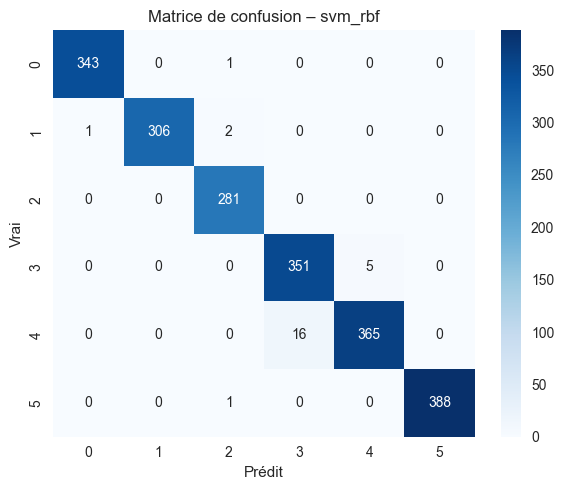

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title(f"Matrice de confusion – {best_model_name}")
plt.tight_layout()
plt.show()


{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


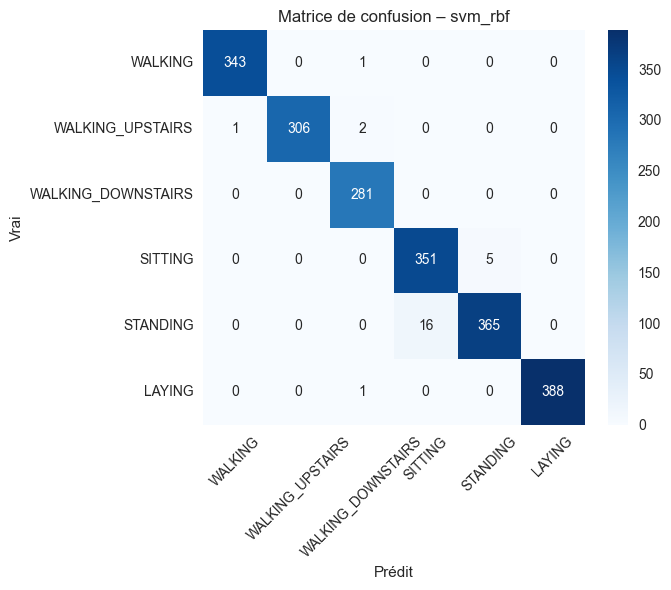

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

activity_labels_df = pd.read_csv(
    r"D:\Projet_ML\MLFLOW_HumanActivity\data\raw\UCI HAR Dataset\activity_labels.txt",
    sep=r"\s+",
    header=None,
    names=["id", "label"],
)

activity_labels = dict(zip(activity_labels_df["id"], activity_labels_df["label"]))

print(activity_labels)


labels_sorted = [activity_labels[i] for i in sorted(activity_labels.keys())]

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels_sorted,
    yticklabels=labels_sorted,
)
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title(f"Matrice de confusion – {best_model_name}")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd


report_dict = classification_report(
    y_test,
    y_pred_best,
    output_dict=True
)

report_df = pd.DataFrame(report_dict).T
report_df


,precision,recall,f1-score,support
1,0.997093,0.997093,0.997093,344.000000
2,1.000000,0.990291,0.995122,309.000000
3,0.985965,1.000000,0.992933,281.000000
4,0.956403,0.985955,0.970954,356.000000
5,0.986486,0.958005,0.972037,381.000000
6,1.000000,0.997429,0.998713,389.000000
accuracy,0.987379,0.987379,0.987379,0.987379
macro avg,0.987658,0.988129,0.987809,2060.000000
weighted avg,0.987567,0.987379,0.987385,2060.000000


In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

classes = np.unique(y_test)
y_test_bin = label_binarize(y_test, classes=classes)


y_proba = best_model.predict_proba(X_test_scaled)

fpr = {}
tpr = {}
roc_auc = {}

for i, cls in enumerate(classes):
    fpr[cls], tpr[cls], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc[cls] = auc(fpr[cls], tpr[cls])

roc_auc



{np.int64(1): 0.9999983059576083,
 np.int64(2): 0.9999852141818175,
 np.int64(3): 0.9999979995959184,
 np.int64(4): 0.9989598169541594,
 np.int64(5): 0.9990855074027004,
 np.int64(6): 1.0}

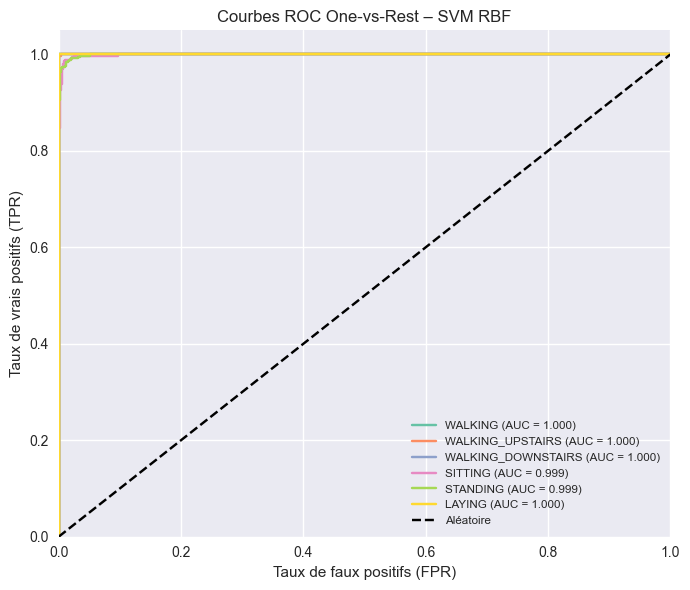

In [ ]:
plt.figure(figsize=(7,6))

for cls in classes:
    label = activity_labels[cls] if 'activity_labels' in globals() else f"Classe {cls}"
    plt.plot(fpr[cls], tpr[cls], label=f"{label} (AUC = {roc_auc[cls]:.3f})")

plt.plot([0, 1], [0, 1], "k--", label="Aléatoire")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbes ROC One-vs-Rest – SVM RBF")
plt.legend(loc="lower right", fontsize="small")
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    estimator=best_model,
    X=X_train_scaled,
    y=y_train,
    cv=3,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring="accuracy",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure(figsize=(7,5))
plt.plot(train_sizes, train_mean, "o-", label="Score entraînement")
plt.plot(train_sizes, val_mean, "o-", label="Score validation")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(train_sizes, val_mean-val_std, val_mean+val_std, alpha=0.2)

plt.xlabel("Taille de l'échantillon d'entraînement")
plt.ylabel("Accuracy")
plt.title("Courbe d'apprentissage – SVM RBF")
plt.ylim(0.9, 1.0)
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'best_model' is not defined

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import trange

n_boot = 1000
n = len(y_test)

boot_accs = []

for _ in trange(n_boot):
    
    idx = np.random.choice(np.arange(n), size=n, replace=True)
    acc = accuracy_score(y_test[idx], y_pred_best[idx])
    boot_accs.append(acc)

boot_accs = np.array(boot_accs)

print("Bootstrap mean accuracy:", boot_accs.mean())
print("Bootstrap std:", boot_accs.std())

lower = np.percentile(boot_accs, 2.5)
upper = np.percentile(boot_accs, 97.5)

print(f"95% confidence interval: [{lower:.4f}, {upper:.4f}]")


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 587.23it/s]

Bootstrap mean accuracy: 0.9873970873786407
Bootstrap std: 0.0024183604650778873
95% confidence interval: [0.9825, 0.9917]


In [ ]:
from pathlib import Path
import joblib

models_dir = Path("/models")
models_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(best_model, models_dir / "best_model.joblib")
joblib.dump(scaler, models_dir / "scaler.joblib")

print(f"Saved best model ({best_model_name}) and scaler in {models_dir}")


Saved best model (svm_rbf) and scaler in \models


In [ ]:
for name, res in grid_results.items():
    best_model = res["best_estimator"]
    best_params = res["best_params"]
    cv_score = res["cv_score"]
    test_acc = res["test_accuracy"]

    with mlflow.start_run(run_name=f"gridsearch_best_{name}"):
       
        mlflow.log_params(best_params)

        
        mlflow.log_metric("cv_accuracy", cv_score)
        mlflow.log_metric("test_accuracy", test_acc)

      
        mlflow.log_param("model_name", name)

        
        mlflow.sklearn.log_model(best_model, "model")

print("Runs MLflow créés pour : ", list(grid_results.keys()))


2025/11/23 16:15:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 16:15:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/23 16:15:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 16:15:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/11/23 16:15:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 16:16:07 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Runs MLflow créés pour :  ['log_reg', 'random_forest', 'svm_rbf']


In [ ]:
try:
    mlflow_sklearn.autolog(disable=True)
    print("mlflow.sklearn.autolog désactivé.")
except Exception as e:
    print(" Impossible de désactiver mlflow.sklearn.autolog :", e)

MLFLOW_UI_URL = "http://127.0.0.1:5000/"

print("Dossier mlruns utilisé :", mlruns_path)
print("Tracking URI MLflow   :", mlflow.get_tracking_uri())
print(" Pour lancer l'UI MLflow ")

print("mlflow ui --backend-store-uri file:mlruns --port 5000")
print("Puis ouvre dans ton navigateur :", MLFLOW_UI_URL)

⚠️ Impossible de désactiver mlflow.sklearn.autolog : name 'mlflow_sklearn' is not defined
📁 Dossier mlruns utilisé : C:\Users\hp\mlruns
📌Tracking URI MLflow   : file:///C:/Users/hp/mlruns
 Pour lancer l'UI MLflow 😊
mlflow ui --backend-store-uri file:mlruns --port 5000
Puis ouvre dans ton navigateur : http://127.0.0.1:5000/


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

seeds = [0, 1, 2, 3, 4, 5, 6]

for seed in seeds:
    print(f"\n=== SVM run avec random_state={seed} ===")

  
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
        X_full,
        y_full,
        test_size=0.2,
        random_state=seed,
        stratify=y_full
    )

    scaler_s = StandardScaler()
    X_train_s_scaled = scaler_s.fit_transform(X_train_s)
    X_test_s_scaled = scaler_s.transform(X_test_s)

    svm_model = SVC(
        kernel="rbf",
        C=10.0,
        gamma="scale",
        probability=True,
        random_state=42 
    )

    svm_model.fit(X_train_s_scaled, y_train_s)
    y_pred_s = svm_model.predict(X_test_s_scaled)
    acc_s = accuracy_score(y_test_s, y_pred_s)

    print(f"Accuracy (seed={seed}): {acc_s:.4f}")

    with mlflow.start_run(run_name=f"SVM_seed_{seed}"):
        mlflow.log_param("model_name", "svm_rbf")
        mlflow.log_param("C", 10.0)
        mlflow.log_param("gamma", "scale")
        mlflow.log_param("train_test_seed", seed)

        mlflow.log_metric("test_accuracy", acc_s)

        mlflow.sklearn.log_model(svm_model, "model")
    


=== SVM run avec random_state=0 ===


2025/11/23 20:48:40 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy (seed=0): 0.9835


2025/11/23 20:48:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== SVM run avec random_state=1 ===
Accuracy (seed=1): 0.9927


2025/11/23 20:49:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/11/23 20:49:57 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== SVM run avec random_state=2 ===


2025/11/23 20:50:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy (seed=2): 0.9869


2025/11/23 20:50:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== SVM run avec random_state=3 ===


2025/11/23 20:51:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy (seed=3): 0.9859


2025/11/23 20:51:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== SVM run avec random_state=4 ===


2025/11/23 20:52:25 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy (seed=4): 0.9942


2025/11/23 20:52:34 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== SVM run avec random_state=5 ===


2025/11/23 20:53:18 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy (seed=5): 0.9903


2025/11/23 20:53:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.



=== SVM run avec random_state=6 ===


2025/11/23 20:54:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy (seed=6): 0.9908


2025/11/23 20:54:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
